In [9]:
git_repo = '../../../..'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# My libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from copy import deepcopy

import numpy as np
import scipy as sp

np.random.seed(453453)

from sklearn.decomposition import PCA

import json 

In [10]:
# Load results from previous fit.
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha8.0_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [11]:
# load some parameters to check
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [12]:
# we plot in PC space
pca_fit = PCA()
pca_fit.fit(model.y)
pc_features = pca_fit.transform(model.y)

In [13]:
# we plot in PCA space
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

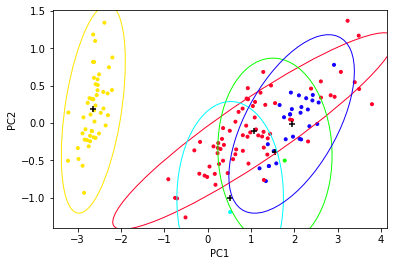

In [15]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

In [16]:
moment_model = gmm_utils.InterestingMoments(model)
linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

AttributeError: module 'gmm_clustering_lib' has no attribute 'LinearSensitivity'

In [6]:
dgdeta = np.zeros(kl_hessian.shape[0])
dgdeta[0] = 1

gh = np.linalg.solve(kl_hessian, dgdeta)
print(gh.shape)

(190,)


In [7]:

q_class = fun_sens_lib.StickSensitivity(model, best_param, kl_hessian, dgdeta)
q_class.model.global_vb_params.set_free(best_param)
print(q_class.get_log_q_logit_stick(0.5, 0))
print(q_class.log_q_logit_stick_obj.fun_free(best_param, logit_v=0.5, k=0))

#print(best_param)
q_class.model.global_vb_params.set_free(best_param)
#print(q_class.log_q_logit_stick_obj.fun_free_grad(best_param, logit_v=0.5, k=0))

print('---------\n')
print(q_class.get_log_q_logit_stick(0.5, 0))
print(q_class.get_log_p0_logit_stick(0.1))

print('\n--------- all:')
print(q_class.get_log_q_logit_all_sticks(0.1))

print('---------\n')
print(q_class.get_single_stick_influence(logit_v=0, k=0))
print(q_class.get_all_stick_influence(logit_v=0.1))


-11.603569234549244
-11.603569234549244
---------

-11.603569234549244
[-6.59956994]

--------- all:
[ -1.82848708   1.49274545 -10.24707754 -10.04616073  -9.61651448
  -9.46586718  -9.33730754  -9.22151605  -9.11550095  -9.01766991
  -8.92698158]
---------

[-1.01970933]
0.9712691608696834


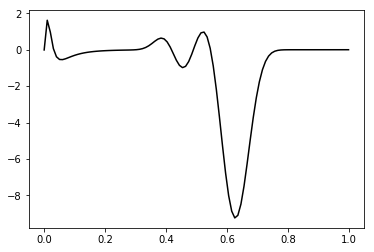

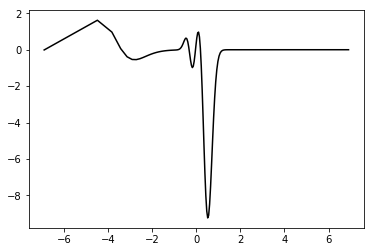

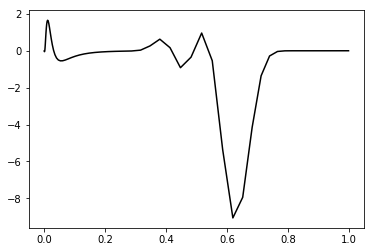

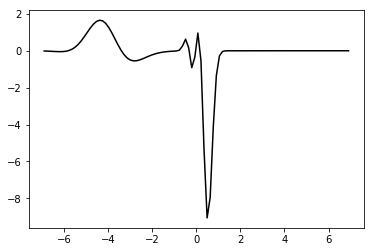

In [8]:
v_grid = np.linspace(1e-3, 1 - 1e-3, num=100)
logit_v_grid = np.log(v_grid / (1 - v_grid))

plt.figure()
influence_grid = np.array(
    [ q_class.get_all_stick_influence(logit_v=logit_v) for
      logit_v in logit_v_grid ])
plt.plot(v_grid, influence_grid, 'k')
plt.figure()
plt.plot(logit_v_grid, influence_grid, 'k')

logit_v_min = np.log(1e-3 / (1 - 1e-3))
logit_v_max = np.log((1 - 1e-3) / 1e-3)
logit_v_grid = np.linspace(logit_v_min, logit_v_max, num=100)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

influence_grid = np.array(
    [ q_class.get_all_stick_influence(logit_v=logit_v) for
      logit_v in logit_v_grid ])
plt.figure()
plt.plot(v_grid, influence_grid, 'k')
plt.figure()
plt.plot(logit_v_grid, influence_grid, 'k')



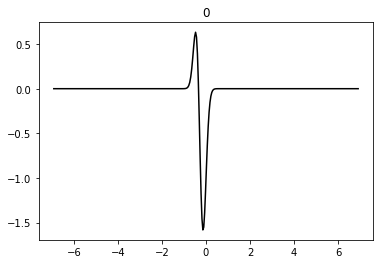

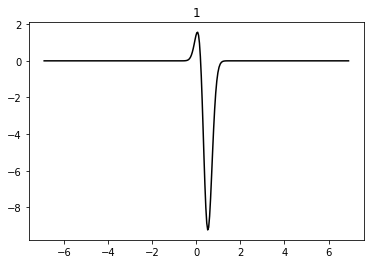

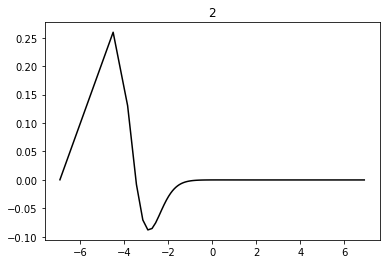

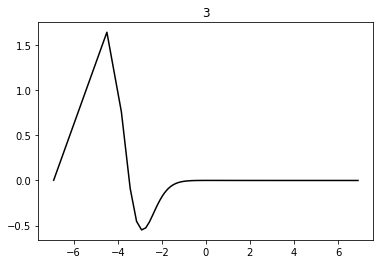

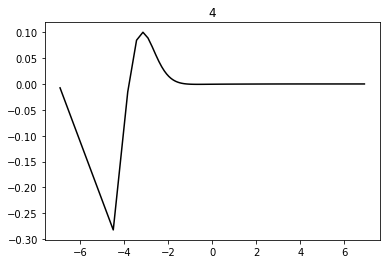

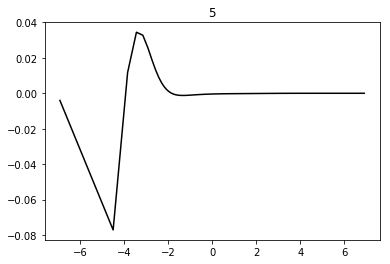

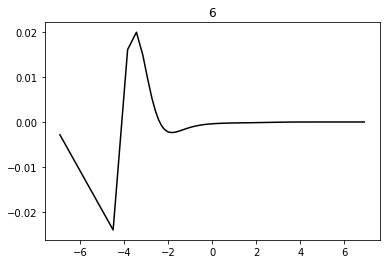

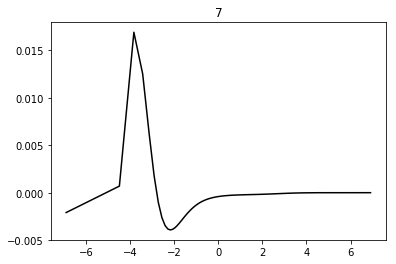

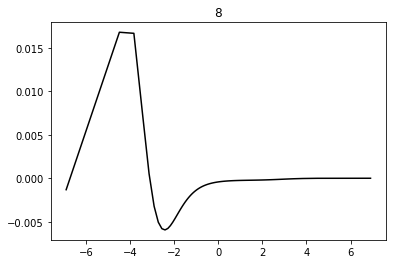

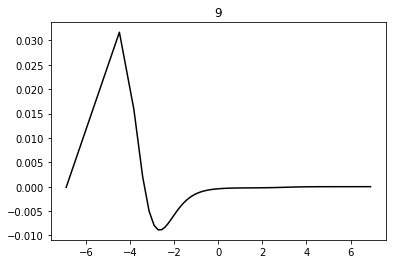

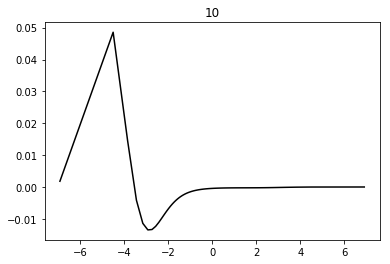

In [9]:
v_grid = np.linspace(1e-3, 1 - 1e-3, num=100)
logit_v_grid = np.log(v_grid / (1 - v_grid))

for k in range(model.k_approx - 1):
    influence_grid = np.array(
        [ q_class.get_single_stick_influence(logit_v=logit_v, k=k) for
          logit_v in logit_v_grid ])
    plt.figure()
    plt.plot(logit_v_grid, influence_grid, 'k')
    plt.title(k)